In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.manifold import TSNE

In [2]:
csv_filepath = "/home/kelvin/c487/data/features/csvs/"
label_file   = "/home/kelvin/c487/data/ground_truth.csv"

csvs = os.listdir(csv_filepath)
csvs.sort()

total       = len(csvs)
percent     = int(round(total * 0.01))
i           = 0
progress    = i/total * 100

prog_template = "Gathering feature data...{:.3f}%"
time_template = "(time elapsed: {:.3f}s)"

filenames = []
emotions  = []

classes        = np.empty((total, ))
training_data  = np.empty((total, 6375))
training_class = np.empty((total, ))
predict_data   = np.empty((total, 6375))
predict_class  = np.empty((total, ))

emotion_counter = {1: 0, # Neutral State
                   2: 0, # Sadness
                   3: 0, # Anger
                   4: 0} # Happiness

In [3]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['Neutral', 'Sadness', 'Anger', 'Happiness']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [5]:
def clean_data(data):
    data = data[:, ~np.isnan(data).any(axis=0)]
    data = data[~np.all(data == 0, axis = 1)]
    
    return data

In [6]:
def clean_labels(labels):
    labels = labels.astype(int)
    labels = labels[labels > 0]
    
    return labels

In [7]:
# Load in ground truth data
with open(label_file, 'r') as labels:
    for row in labels.readlines():
        col = row.split(',')

        filenames.append(col[0])
        emotions.append(col[1])
        emo_enum = col[2][0]

        try:
            classes[i] = int(emo_enum)
            i += 1
        except ValueError:
            continue

In [8]:
# Extract feature data from csv files
i = 0
training_index = 0
predict_index = 0
t0 = time.time()

print(prog_template.format(progress))

for csv in csvs:
    data = np.genfromtxt(csv_filepath+csv, delimiter=',')

    if emotion_counter[classes[i]] % 2 and emotion_counter[classes[i]] < 495:
        training_data[training_index] = data[1]
        training_class[training_index] = classes[i]
        training_index += 1
    else:
        predict_data[predict_index] = data[1]
        predict_class[predict_index] =  classes[i]
        predict_index += 1

    emotion_counter[classes[i]] += 1
    i += 1

    if (i % percent == 0):
        progress = i/total * 100
        print(prog_template.format(progress))

elapsed_t = time.time() - t0
print("Done " + time_template.format(elapsed_t))

#print(emotion_counter)

Gathering feature data...0.000%
Gathering feature data...1.005%
Gathering feature data...2.010%
Gathering feature data...3.016%
Gathering feature data...4.021%
Gathering feature data...5.026%
Gathering feature data...6.031%
Gathering feature data...7.036%
Gathering feature data...8.041%
Gathering feature data...9.047%
Gathering feature data...10.052%
Gathering feature data...11.057%
Gathering feature data...12.062%
Gathering feature data...13.067%
Gathering feature data...14.072%
Gathering feature data...15.078%
Gathering feature data...16.083%
Gathering feature data...17.088%
Gathering feature data...18.093%
Gathering feature data...19.098%
Gathering feature data...20.103%
Gathering feature data...21.109%
Gathering feature data...22.114%
Gathering feature data...23.119%
Gathering feature data...24.124%
Gathering feature data...25.129%
Gathering feature data...26.134%
Gathering feature data...27.140%
Gathering feature data...28.145%
Gathering feature data...29.150%
Gathering feature da

In [9]:
# Remove empty rows, NaNs, etc.
training_data = clean_data(training_data)
training_class = clean_labels(training_class)

predict_data = clean_data(predict_data)
predict_class = clean_labels(predict_class)

In [10]:
# Feature selection
#sel = VarianceThreshold(threshold = 0.5)

#training_data = sel.fit_transform(training_data)
#predict_data  = sel.fit_transform(predict_data)

#training_data = SelectKBest(f_classif, k=5).fit_transform(training_data, training_class)
#predict_data  = SelectKBest(f_classif, k=5).fit_transform(predict_data, predict_class)

In [11]:
# Verify matrix sizes
print(training_data.shape)
print(training_class.shape)
print(predict_data.shape)
print(predict_class.shape)

(988, 6373)
(988,)
(2494, 6373)
(2494,)


In [12]:
# Train SVM model
print("Training SVM...")
t0 = time.time()

classifier = svm.SVC(gamma = 'scale')
classifier.fit(training_data, training_class)

elapsed_t = time.time() - t0
print("Training Finished " + time_template.format(elapsed_t))

Training SVM...
Training Finished (time elapsed: 11.020s)


In [13]:
# Predict
print("Classifying data with SVM model...")
t0 = time.time()

predicted = classifier.predict(predict_data)

elapsed_t = time.time() - t0
print("Prediction Complete " + time_template.format(elapsed_t))

Classifying data with SVM model...
Prediction Complete (time elapsed: 19.272s)


Normalized confusion matrix
[[0.23170732 0.33231707 0.43597561 0.        ]
 [0.21047009 0.38034188 0.40918803 0.        ]
 [0.29226069 0.21995927 0.48778004 0.        ]
 [0.19354839 0.43951613 0.36693548 0.        ]]


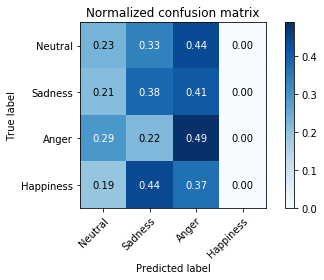

In [14]:
# Plot confusion matrix
plot_confusion_matrix(predict_class, predicted, classes, True)
plt.show()

{1: 575, 2: 1183, 3: 1229, 4: 495}


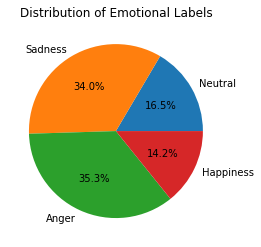

In [15]:
print(emotion_counter)
plt.pie([575, 1183, 1229, 495],
        labels = ['Neutral', 'Sadness', 'Anger', 'Happiness'],
        autopct = '%1.1f%%');
plt.title("Distribution of Emotional Labels");

In [16]:
# Dimension reduction using TSNE
training_tsne = TSNE(n_components=2).fit_transform(training_data)
test_tsne     = TSNE(n_components=2).fit_transform(predict_data)

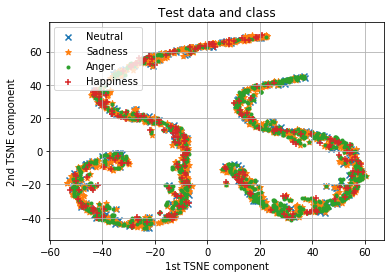

In [17]:
test_neu = test_tsne[predict_class == 1]
test_sad = test_tsne[predict_class == 2]
test_ang = test_tsne[predict_class == 3]
test_hap = test_tsne[predict_class == 4]

plt.title("Test data and class");
plt.grid();
plt.xlabel("1st TSNE component");
plt.ylabel("2nd TSNE component");
plt.scatter(test_neu[:,0], test_neu[:,1], marker='x');
plt.scatter(test_sad[:,0], test_sad[:,1], marker='*');
plt.scatter(test_ang[:,0], test_ang[:,1], marker='.');
plt.scatter(test_hap[:,0], test_hap[:,1], marker='+');
plt.legend(['Neutral', 'Sadness', 'Anger', 'Happiness'], loc=2);

In [18]:
clf_tsne = svm.SVC(gamma = 'scale')
clf_tsne.fit(training_tsne, training_class)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Normalized confusion matrix
[[0.24695122 0.21646341 0.36585366 0.17073171]
 [0.26068376 0.22115385 0.33867521 0.17948718]
 [0.26069246 0.13543788 0.49490835 0.1089613 ]
 [0.25806452 0.21370968 0.3266129  0.2016129 ]]


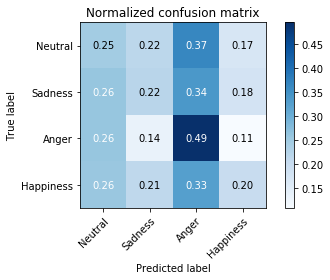

In [19]:
y = clf_tsne.predict(test_tsne)

plot_confusion_matrix(predict_class, y, classes, True)
plt.show()

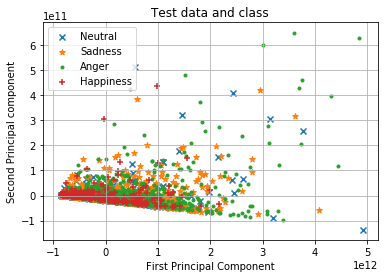

In [20]:
# Dimension reduction using PCA
pca = PCA(n_components=2)

pca.fit(training_data)
training_pca = pca.transform(training_data)
test_pca = pca.transform(predict_data)

# Plot of test data and class
test_neu = test_pca[predict_class == 1]
test_sad = test_pca[predict_class == 2]
test_ang = test_pca[predict_class == 3]
test_hap = test_pca[predict_class == 4]

plt.title("Test data and class");
plt.grid();
plt.xlabel("First Principal Component");
plt.ylabel("Second Principal component");
plt.scatter(test_neu[:,0], test_neu[:,1], marker='x');
plt.scatter(test_sad[:,0], test_sad[:,1], marker='*');
plt.scatter(test_ang[:,0], test_ang[:,1], marker='.');
plt.scatter(test_hap[:,0], test_hap[:,1], marker='+');
plt.legend(['Neutral', 'Sadness', 'Anger', 'Happiness'], loc=2);

In [21]:
# Plot of svm predicted data and class
correct_labels = predict_class[predict_class == predicted]
correct = test_pca[predict_class == predicted]

correct_neu = correct[correct_labels == 1]
correct_sad = correct[correct_labels == 2]
correct_ang = correct[correct_labels == 3]
correct_hap = correct[correct_labels == 4]

'''
plt.title("Classification Groupings from SVM Model");
plt.grid()
plt.xlabel("First Principal Component");
plt.ylabel("Second Principal component");
plt.scatter(test_neu[:,0], test_neu[:,1], marker='x', color='m');
plt.scatter(test_sad[:,0], test_sad[:,1], marker='*', color='c');
plt.scatter(test_ang[:,0], test_ang[:,1], marker='.', color='0.8');
plt.scatter(test_hap[:,0], test_hap[:,1], marker='+')
plt.legend(['Neutral', 'Sadness', 'Anger', 'Happiness'], loc=2);
'''

'\nplt.title("Classification Groupings from SVM Model");\nplt.grid()\nplt.xlabel("First Principal Component");\nplt.ylabel("Second Principal component");\nplt.scatter(test_neu[:,0], test_neu[:,1], marker=\'x\', color=\'m\');\nplt.scatter(test_sad[:,0], test_sad[:,1], marker=\'*\', color=\'c\');\nplt.scatter(test_ang[:,0], test_ang[:,1], marker=\'.\', color=\'0.8\');\nplt.scatter(test_hap[:,0], test_hap[:,1], marker=\'+\')\nplt.legend([\'Neutral\', \'Sadness\', \'Anger\', \'Happiness\'], loc=2);\n'

In [22]:
clf_pca = svm.SVC(gamma = 'scale');
clf_pca.fit(training_pca, training_class);

# Plot decision boundary
x_min, x_max = test_pca[:,0].min() - 1, test_pca[:,0].max() + 1
y_min, y_max = test_pca[:,1].min() - 1, test_pca[:,1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, x_max/1000),
                     np.arange(y_min, y_max, x_max/1000))

Z = clf_pca.predict(np.c_[xx.ravel(), yy.ravel()])

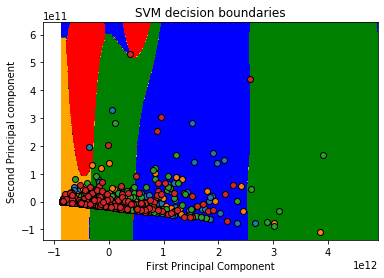

In [23]:
# Plot of training data and class
test_neu = training_pca[training_class == 1]
test_sad = training_pca[training_class == 2]
test_ang = training_pca[training_class == 3]
test_hap = training_pca[training_class == 4]

#plt.figure(figsize=(15, 12))
#plt.rc('font', size = 25)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, colors=('b', 'g', '#ffa500', 'r'));

plt.title("SVM decision boundaries");
plt.xlabel("First Principal Component");
plt.ylabel("Second Principal component");
plt.scatter(test_neu[:,0], test_neu[:,1], edgecolors='k');
plt.scatter(test_sad[:,0], test_sad[:,1], edgecolors='k');
plt.scatter(test_ang[:,0], test_ang[:,1], edgecolors='k');
plt.scatter(test_hap[:,0], test_hap[:,1], edgecolors='k');
#plt.legend(['Neutral', 'Sadness', 'Anger', 'Happiness']);